# __Customer Segmentation Project__

Code example sourced from: https://github.com/SarahMestiri/online-retail-case/blob/master/Customer%20Segmentation%20-%20Online%20retail.ipynb

The author of the code is Sarah Mestiri. I found her analysis very thorough and decided to use it as an example for my project by adding some visualization and deploying it into dash. 

The **goals** of this project is to improve revenues of the company by segmentation of its customers and then target them with personal offers.

__Plan of Attack:__

1. Do **RFM Analysis** 

2. Combine RFM with **predictive algorithms (k-means)**.

__RFM Analysis__ answers the following questions:

* Who are our best customers?
* Who has the potential to be converted in more profitable customers?
* Which customers we must retain?
* Which group of customers is most likely to respond to the marketing campaign?

More about RFM [here](https://putler.com/rfm-analysis/).

## __Import Necessary Modules__

In [0]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt
import altair as alt

#Predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

#Data viz
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings('ignore')

## __Data pre-Processing__

In [0]:
#Load the dataset
retail_df = pd.read_excel('/content/Online Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
retail_df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [0]:
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [0]:
#Remove cancelled orders
retail_uk = retail_uk[retail_uk['Quantity'] > 0]
retail_uk.shape

(486286, 8)

In [0]:
#Remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'], how='all', inplace=True)
retail_uk.shape

(354345, 8)

In [0]:
#Restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate'] >= '2010-12-09']
retail_uk.shape

(342478, 8)

In [0]:
print('Summary...')

#Exploring the unique values of each attribute
print('Number of transactions: ', retail_uk['InvoiceNo'].nunique())
print('Number of products bought: ',retail_uk['StockCode'].nunique())
print('Number of customers: ', retail_uk['CustomerID'].nunique() )
print('Percentage of customers NA: ', round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df), 2), '%' )

Summary...
Number of transactions:  16017
Number of products bought:  3611
Number of customers:  3863
Percentage of customers NA:  0.0 %


In [0]:
retail_uk.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom
541893,581586,20685,DOORMAT RED RETROSPOT,10,2011-12-09 12:49:00,7.08,13113.0,United Kingdom


##__RFM Analysis__

RFM divides customers into various categories or clusters based on three criteria and helps to personalize product offers and marketing campain.

**RECENCY (R)**: Days since last purchase

**FREQUENCY (F)**: Total number of purchases

**MONETARY VALUE (M)**: Total money this customer spent.

### __Recency__

In [0]:
#Last date available in our dataset
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [0]:
now = dt.date(2011, 12, 9)
print(now)

2011-12-09


In [0]:
#Create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [0]:
#Group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID', 'LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [0]:
#Calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [0]:
#Drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate', axis=1, inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


In [0]:
recency_df.sort_values(by=['Recency'], ascending=False)

,CustomerID,Recency
2206,15945.0,365
1074,14355.0,365
2290,16065.0,365
3647,17978.0,365
3277,17456.0,365
...,...,...
1135,14446.0,0
3729,18102.0,0
862,14051.0,0
2187,15910.0,0


###__Frequency__

It shows how many times a customer purchased from the company. To do that we need to check how many invoices are registered by the same customer.

In [0]:
#Drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep='first', inplace=True)

#Calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


In [0]:
frequency_df.sort_values(by=['Frequency'], ascending=False)

,CustomerID,Frequency
2,12748.0,196
3549,17841.0,121
188,13089.0,94
1255,14606.0,90
1752,15311.0,88
...,...,...
2538,16406.0,1
2536,16404.0,1
2535,16403.0,1
2534,16402.0,1


### __Monetary__

How much money did the customer spent over time?

In [0]:
#Create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [0]:
monetary_df = retail_uk.groupby(by='CustomerID', as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


In [0]:
monetary_df.sort_values(by='Monetary', ascending=False)

,CustomerID,Monetary
2567,16446.0,168471.25
0,12346.0,77183.60
1591,15098.0,39916.50
3729,18102.0,39646.45
3626,17949.0,28685.69
...,...,...
1885,15503.0,0.42
1993,15645.0,0.42
322,13271.0,0.39
3602,17914.0,0.39


###__Create RFM Table__


In [0]:
#Merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df, on='CustomerID')
#Merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df, on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,10,658.89
2,12748.0,0,196,3739.23
3,12749.0,3,5,98.35
4,12820.0,3,4,58.20


In [0]:
#Use CustomerID as index
rfm_df.set_index('CustomerID', inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


### __RFM Table Correctness verification__

In [0]:
retail_uk[retail_uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [0]:
#Check correctness of Recency
(now - dt.date(2011, 1, 18)).days == 325

True

###__Customer segments with RFM Model__

Application of __Pareto Principle__ to our RFM variables.

Pareto’s rule says that **80% of the results come from 20% of the causes.**

Thus **20% customers contribute to 80% of company's total revenue**. Our goal here in this section is to verify that.

In [0]:
#Get the 80% of the revenue
pareto_threshold = rfm_df['Monetary'].sum() * 0.8
print('The 80% of total revenue is: ', round(pareto_threshold, 2))

The 80% of total revenue is:  890679.54


In [0]:
customers_rank = rfm_df
#Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=False)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


In [0]:
customers_rank.max()

Recency         365.00
Frequency       196.00
Monetary     168471.25
Rank           3863.00
dtype: float64

###__Top Customers__

In [0]:
customers_rank.sort_values('Rank', ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3859.5
15645.0,18,1,0.42,3859.5
17914.0,3,1,0.39,3861.5


In [0]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [0]:
#sum the monetary values over the customer with rank <=773
revenueTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueTop20

976683.3499999999

__Conclusion__: we can see that 80% of total revenue is:  __890679__, and the revenue from top 20 customers is __976683__. Which means that our 20% of top customers make even more than 80% of the total revenue. Thus, we can see that Pareto Principle works here. 

Now we need to explore these top 20% customers more. 

###__Applying RFM score formula__

The simplest way to create customers segments from RFM Model is to use __Quartiles (score from 1 to 4)__ or __Quintiles (score from 1-5)__, it's just depends on business needs. In our case it is easier to use quartiles. So, we assign a score from 1 to 4 to Recency, Frequency and Monetary. 
* __1__ - best/highest value
* __4__ - the lowest/worst value. 

A final RFM score is calculated simply by combining individual RFM score numbers.

####__RFM Quartiles__

In [0]:
quantiles = rfm_df.quantile(q=[0.25, 0.5, 0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


In [0]:
quantiles.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0},
 'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0}}

####__Creation of RFM segmentation table__
Create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [0]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [0]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency', quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary', quantiles,))

In [0]:
rfm_segmentation = rfm_segmentation.drop(columns=['Rank'])
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,10,658.89,1,1,1
12748.0,0,196,3739.23,1,1,1
12749.0,3,5,98.35,1,2,2
12820.0,3,4,58.20,1,2,2


Now we can combine the scores (R_Quartile, F_Quartile, M_Quartile) together and present our customer segmentation

In [0]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,10,658.89,1,1,1,111
12748.0,0,196,3739.23,1,1,1,111
12749.0,3,5,98.35,1,2,2,122
12820.0,3,4,58.20,1,2,2,122


Our best customers should have the highest of these three scores:
* __Best Recency score = 1__: means most recently purchase. 
* __Best Frequency score = 1__: highest number of purchases. 
* __Best Monetary score = 1__: spent the most.

In [0]:
rfm_segmentation[rfm_segmentation['RFMScore']=='111'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
18102.0,0,57,39646.45,1,1,1,111
17949.0,1,44,28685.69,1,1,1,111
17450.0,8,44,25953.51,1,1,1,111
16013.0,3,45,17163.28,1,1,1,111
16333.0,7,22,14418.96,1,1,1,111
15769.0,7,25,11660.84,1,1,1,111
12901.0,8,28,9230.45,1,1,1,111
13798.0,1,56,7786.26,1,1,1,111
16684.0,4,28,7700.08,1,1,1,111


In [0]:
df = rfm_segmentation.groupby('RFMScore')
df2 = rfm_segmentation.groupby('F_Quartile')
df3 = rfm_segmentation.groupby('M_Quartile')

best_customers_monetary = (df.get_group('111'))['Monetary'].sum()
loyal_customers_monetary = (df2.get_group(1))['Monetary'].sum()
big_spenders_monetary = df3.get_group(1)['Monetary'].sum()
almost_lost_customers_monetary = (df.get_group('311'))['Monetary'].sum()
lost_customers_monetary = (df.get_group('411'))['Monetary'].sum()
lost_cheap_customers_monetary = (df.get_group('444'))['Monetary'].sum()

In [0]:
best_customers_recency = (df.get_group('111'))['Recency'].mean()
loyal_customers_recency = (df2.get_group(1))['Recency'].mean()
big_spenders_recency = df3.get_group(1)['Recency'].mean()
almost_lost_customers_recency = (df.get_group('311'))['Recency'].mean()
lost_customers_recency = (df.get_group('411'))['Recency'].mean()
lost_cheap_customers_recency = (df.get_group('444'))['Recency'].mean()

In [0]:
rfm_segmentation.to_csv('RFM_Segmentation.csv')

The suggestion of key segments can be found [here](https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales). We can assign them to our groups of customers.

We can also count how many customers do we have in each segment?

In [0]:
print('Best Customers: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ', len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print('Big Spenders: ', len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='311']))
print('Lost Customers: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='411']))
print('Lost Cheap Customers: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  64
Lost Customers:  9
Lost Cheap Customers:  353


Now when the customers categorized the company can personalize marketing campain to each of these customer groups. 

Also, now we can analyse relationship between RFM variables and build a predictive models by using k-means clustering, Logistic Regression and Recommendation to produce better informative results on customer behavior.

__K-means__ is being widely used for Market Segmentation and it offers the advantage of being simple to implement, following Andrew Ng who advice in his Machine Learning course, start with a dirty and simple model then move to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.

##__Applying K-means clustering on RFM variables__


###__Preprocess Data__

In [0]:
rfm_data = rfm_segmentation.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'], axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


###__Feature correlations__

In [0]:
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.279236,-0.027727
Frequency,-0.279236,1.000000,0.156431
Monetary,-0.027727,0.156431,1.000000


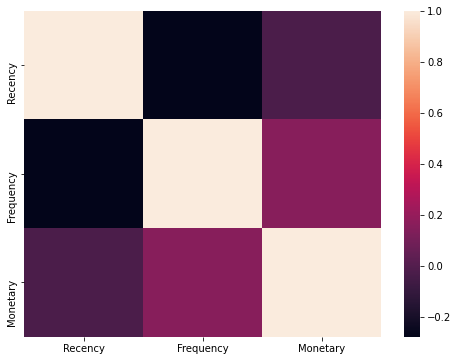

In [0]:
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_data.corr())

We can see that Monetary-Recency are slightly positively correlated. Frequency-Recency are opposite.

###__Visualize feature distributions__

Let's plot a scatter matrix of each of the three features presented in the RFM data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f544b58fd30>,
      dtype=object)

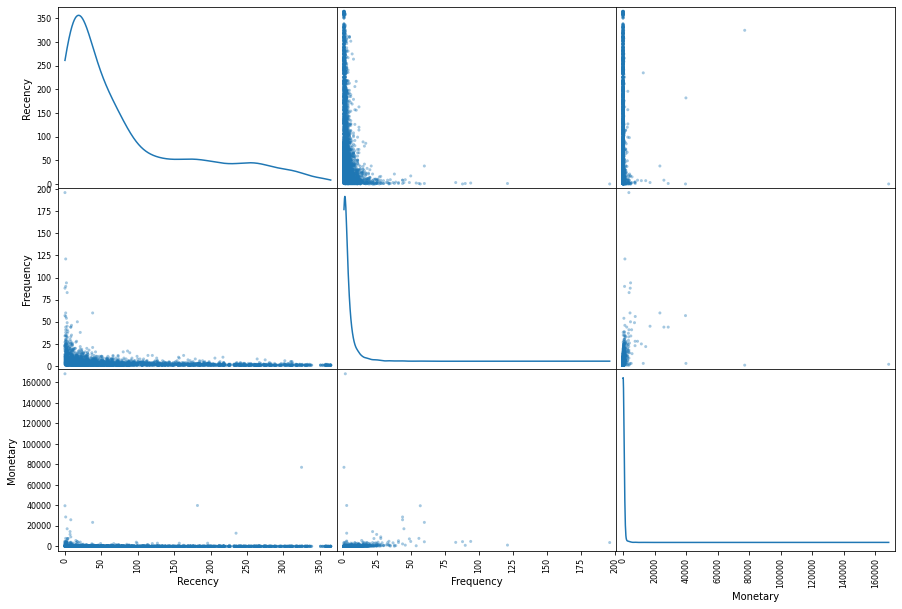

In [0]:
scatter_matrix(rfm_data, alpha = 0.4, figsize = (15, 10), diagonal = 'kde')

We can see some outliers and also a skewed distribution. It indicates that we need to normalize features from our data to make the data normally distributed, because k-means is sensitive to big numbers. 

###__Data Normalization__

In [0]:
#Use log function to normalize data
rfm_r_log = np.log(rfm_data['Recency'] + 0.1)
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary'] + 0.1)

log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.490708,0.741937,2.302585
12748.0,8.226662,-2.302585,5.278115
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f544b3d5978>,
      dtype=object)

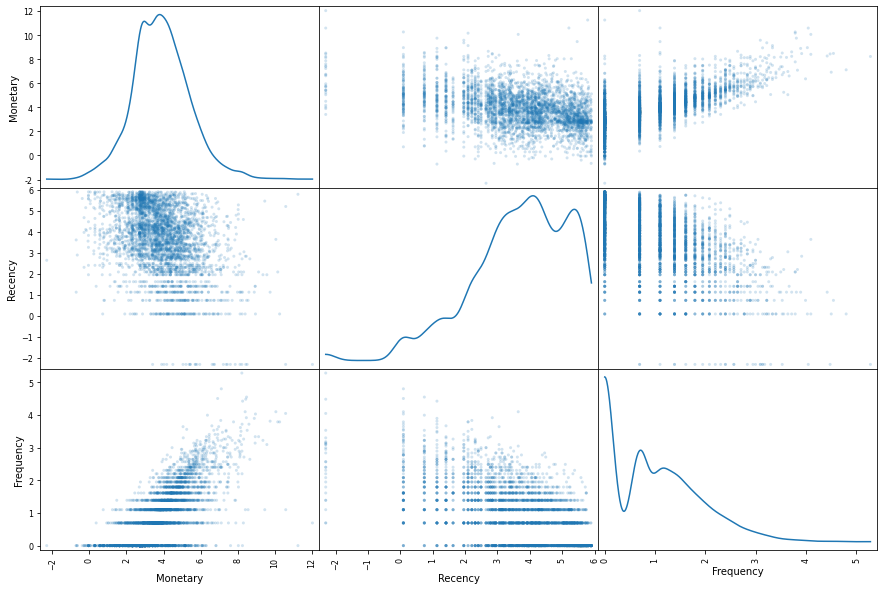

In [0]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_data, alpha = 0.2, figsize = (15, 10), diagonal = 'kde')

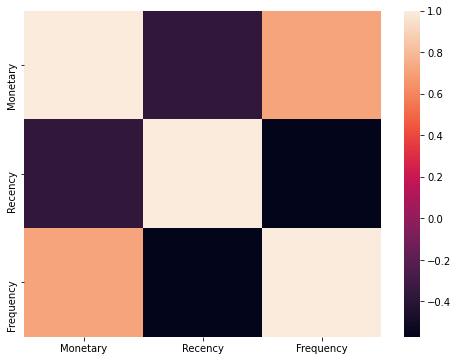

In [0]:
plt.figure(figsize=(8, 6))
sns.heatmap(log_data.corr())

In [0]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.364351,0.715609
Recency,-0.364351,1.000000,-0.569951
Frequency,0.715609,-0.569951,1.000000


We can see that now Frequency-Recency and Monetary-Frequency are more strongly correlated

##__K-means Implementation__
A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The elbow method can be used to determine the number of clusters as well.

Note: K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called k-means++.

In [0]:
matrix = log_data.values
for n_clusters in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.38930787566743014
For n_clusters = 3 The average silhouette_score is : 0.30380548886126
For n_clusters = 4 The average silhouette_score is : 0.30981977259666754
For n_clusters = 5 The average silhouette_score is : 0.2901550155654932
For n_clusters = 6 The average silhouette_score is : 0.29542828811136623
For n_clusters = 7 The average silhouette_score is : 0.29126596642485003
For n_clusters = 8 The average silhouette_score is : 0.2919445651287872
For n_clusters = 9 The average silhouette_score is : 0.2945816519659177


Best score when the number of clusters is 2

In [0]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.389


####__Visualize Clusters__

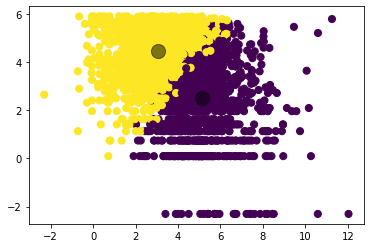

In [0]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')

#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [0]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,1,0
NumberCustomers,2337,1526
